In [91]:
from PIL import Image
from IPython.display import display # to display images
import torchvision as thv
import numpy as np
import matplotlib.pyplot as plt

In [92]:
# Download MNIST dataset
train = thv.datasets.MNIST('./', download=True, train=True)
val = thv.datasets.MNIST('./', download=True, train=False)
print(train.data.shape, len(train.targets))

torch.Size([60000, 28, 28]) 60000


In [93]:
# Visualize dataset
counter = 0
for tuple in train:
    if(counter < 10):
        display(tuple[0])
        counter+=1
    else:
        break

In [94]:
def subsample(dataset, num_samples, num_classes):
    num_samples_per_class = int(num_samples/num_classes)
    dataset = np.array(list(map(lambda elt: (np.array(elt[0]).flatten(),elt[1]), dataset)))
    X, y = map(lambda x: np.array(list(x)),zip(*dataset))
    subsamplesX, subsamplesY = None, None

    for c in range(num_classes):
        # Get all X's where label == c
        mask = np.argwhere(y == c)
        class_X, class_Y = X[mask], y[mask]
        class_X = class_X.reshape((class_X.shape[0], X.shape[1]))
        
        # Get all X's where label == c, inds = index array
        inds = np.random.randint(0, high=class_Y.shape[0], size=num_samples_per_class)
        subsamplesX = class_X[inds] if subsamplesX is None else np.concatenate([subsamplesX, class_X[inds]])
        
        # Get all Y's where label == c
        subsamplesY = class_Y[inds] if subsamplesY is None else np.concatenate([subsamplesY, class_Y[inds]])
    
    # shuffle the arrays
    A = subsamplesX.shape[1]
    B = subsamplesX.shape[0]
    shuf_inds = np.random.shuffle(np.array(range(B)))
    return subsamplesX[shuf_inds].reshape((B,A)), subsamplesY[shuf_inds].reshape((num_samples,))

In [95]:
X_train, y_train = subsample(dataset=train, 
                           num_samples=30000, 
                           num_classes=10)
X_val, y_val = subsample(dataset=val, num_samples=5000, num_classes=10)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

/home/sheil/miniconda3/envs/TF/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


(30000, 784) (30000,)
(5000, 784) (5000,)


In [96]:
class linear_t:
    def __init__(self):
        self.input_size = 784
        self.classes = 10
        
        # initialize to appropriate sizes, fill with Gaussian entries
        # normalize to make Frobenius norm of w, b equal to 1
        self.w = np.random.normal(loc=0, scale=1, size=(self.classes, self.input_size)) 
        self.w = self.w / np.linalg.norm(self.w)
        
        self.b = np.random.normal(loc=0, scale=1, size=(self.classes, 1)) 
        self.b = self.b / np.linalg.norm(self.b)
        
        self.dw = np.zeros_like(self.w)
        self.db = np.zeros_like(self.b)
        
    def forward(self, h_l):
        h_l1 = np.matmul(h_l, np.transpose(self.w)) + self.b.T
        
        # cache h^1 in forward because we will need it to compute
        # dw in backward
        self.hl = h_l
        return h_l1
    
    def backward(self, dh_l1):
        dh_l = np.matmul(dh_l1, self.w)
        dw = np.matmul(dh_l1.T, self.hl)
        db = np.matmul(dh_l1.T, np.ones([self.hl.shape[0], 1]))
        
        self.dw, self.db = dw, db
        return dh_l
    
    def zero_grad(self):
        # useful to delete stored backprop gradients of 
        # previous mini-batch before you start a new mini-batch
        self.dw , self.db = 0*self.dw, 0*self.db

In [97]:
class softmax_cross_entropy_t:
    def __init__(self):
        # no parameters, nothing to initialize
        self.h_l1 = None
        self.y = None
        
    def forward(self, h_l, y):
        expd = np.exp(h_l)
        self.h_l1 = expd / np.sum(expd, axis=1, keepdims=True)
        self.y = y
        # compute average loss ell(y) over a mini-batch
        batch = self.h_l1.shape[0]
        ell = np.sum(-np.log(self.h_l1[range(batch), self.y])) / batch
        error = np.sum(np.not_equal(self.y, np.argmax(self.h_l1, axis=1)) / batch)
        return ell, error
    
    def backward(self):
        # as we saw in notes, backprop input to the
        # loss layer is 1, so this function does not
        # take any arguments
        batch = self.y.shape[0]
        self.h_l1[range(batch), self.y] -= 1
        dh_l = self.h_l1 / batch
        return dh_l
    
    def zero_grad(self):
        pass

In [98]:
class relu_t:
    def forward(self, h_l):
        return np.maximum(0, h_l)
    
    def backward(self, dh_l1):
        x = np.array(dh_l1, copy=True)
        x[x <= 0] = 0
        x[x  > 0] = 1
        return x
    
    def zero_grad(self):
        pass

### Training the neural network

In [100]:
# initialize the layers
l1, l2, l3 = linear_t(), relu_t(), softmax_cross_entropy_t()
net = [l1, l2, l3]
loss = []

In [101]:
# train for atleast 1000 iterations
for t in range(50000):
    # 1. sample a mini-batch of size = 32
    # each image is chosen uniformly randomly
    # from the training dataset
    ix = np.random.randint(0, high=X_train.shape[0], size = 1)
    x, y = X_train[ix], y_train[ix]
    
    # 2. zero gradient buffer
    for l in net:
        l.zero_grad()
        
    # 3. forward pass
    h1 = l1.forward(x)
    h2 = l2.forward(h1)
    ell, error = l3.forward(h2, y)
    
    loss.append(error)
    
    # 4. backward pass
    dh2 = l3.backward()
    dh1 = l2.backward(dh2)
    dx = l1.backward(dh1)
    
    # 5. gather backprop gradients
    dw, db = l1.dw, l1.db
    
    # 6. print some quantities for logging
    # and debugging
    # print(t, ell, error)
    # print(t, np.linalg.norm(dw/l1.w), np.linalg.norm(db/l1.b))
    
    # 7. one step of SGD
    lr = 0.05 # pick any learning rate
    l1.w = l1.w - lr*dw
    l1.b = l1.b - lr*db

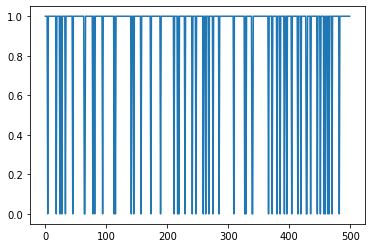

In [102]:
plt.plot(loss[::100])
plt.show()

In [103]:
val_loss = []

In [109]:
validate(w, b):
    # 1. iterate over mini-batches from validation
    # dataset-- should not be done randomly since 
    # we only want to check each image once
    
    loss, tot_error = 0, 0
    for i in range(0, 5000, 32):
        x, y = val.data[i:i+32], val.targets[i:i+32]
        
        # 2. compute forward pass and error
        h1 = l1.forward(x)
        h2 = l2.forward(h1)
        ell, error = l3.forward(h2, y)
        val_loss.append(error)